In [1]:
%matplotlib inline

# Main libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import timeit

# Work with sql
import psycopg2 
from sqlalchemy import create_engine, text, inspect
from sqlalchemy.engine import URL

In [2]:
# Set folder for files
folder = 'bench_files'
sql_folder = ''

# Establish URL for connection to the database 
url_object = URL.create(
    'postgresql+psycopg2',
    username='postgres',
    password='Ee123456!',
    host='localhost',
    database='Masters:Programing_with_python',
)
engine = create_engine(url_object)

# Set plt style
plt.style.use('ggplot')

# Creating dataset

In [11]:
class SynthDF(pd.DataFrame):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    @property
    def _constructor(self):
        return SynthDF
    
    @classmethod
    def create_data(cls, size):
        """
        Create a synthetic DataFrame with random data.

        Parameters
        ----------
        size : int
            Number of rows in the DataFrame.
        """
        df = cls()
        
        # dates
        dates = pd.date_range('2024-01-01', '2024-12-31')
        df['date'] = np.random.choice(dates, size)
        # int data
        df['tournament_id'] = np.arange(size)
        df['team_id'] = np.random.randint(1, 1000, size)
        df['members'] = np.random.randint(1, 10, size)
        # categorical data
        df['location'] = np.random.choice(['Asia', 'Europe', 'Africa', 'America', 'Oceania'], size)
        df['importance'] = np.random.choice(['local', 'minor', 'major'], size)

        # float data
        df['avg_age'] = np.random.randint(100, 500, size) / 10
        df['prize'] = np.random.randint(10000, 10000000, size) / 100
        df['prob'] = np.random.uniform(0, 1, size)
        # bool data
        df['win'] = np.random.choice([True, False], size)
        
        return df

    def dtypes_setter(self):
        """
        Set data types for columns in a synthetic DataFrame.

        - Integers: 'tournament_id' ('int32'), 'team_id' ('int16'), 'members' ('int8').
        - Categorical: 'location', 'importance'.
        - Floats: 'avg_age' ('float16'), 'prize' ('float32'), 'prob' ('float32').
        """

        # int data
        self['tournament_id'] = self['tournament_id'].astype('int32')
        self['team_id'] = self['team_id'].astype('int16')
        self['members'] = self['members'].astype('int8')

        # categorical data
        self['location'] = self['location'].astype('category')
        self['importance'] = self['importance'].astype('category')

        # float data
        self['avg_age'] = self['avg_age'] .astype('float32')
        self['prize'] = self['prize'].astype('float32')
        self['prob'] = self['prob'].astype('float32')

    def benchmark(self, f_name, write_method, read_method, kwargs_write={}, kwargs_read={}):
        """
        Benchmark the performance and space requirements of writing and reading a DataFrame.

        Parameters
        ----------
        f_name : str
            The name of the file to be used for benchmarking.
        write_method : callable
            The method used to write the DataFrame to a file.
        read_method : callable
            The method used to read the DataFrame from a file.
        kwargs_write : dict, optional
            Additional keyword arguments for the write method.
        kwargs_read : dict, optional
            Additional keyword arguments for the read method.

        Returns
        -------
        dict
            A dictionary containing benchmark results.
            - 'format': The file format extension.
            - 'df_size': The size identifier of the DataFrame.
            - 'write': Timing information for the write operation.
            - 'read': Timing information for the read operation.
            - 'size': The size of the file on disk in bytes.
            - 'metadata': Whether metadata (data types) is preserved in the read operation.
        """
        # Set path to file 
        file = os.path.join(folder, f_name)

        # Bench write time
        write = %timeit -o -n 1 -r 3 write_method(self, file, **kwargs_write)

        # Bench read time
        read = %timeit -o -n 1 -r 3 read_method(file, **kwargs_read)

        # Bench size of file
        if write_method == pd.DataFrame.to_sql:
            # Get size of SQL db
            with engine.connect() as conn:
                query = text(f"SELECT pg_total_relation_size('{file}')")
                space = conn.execute(query).scalar()
                f_name += '.sql'
        else:
            # Get size of file 
            space = os.path.getsize(file)
        print(f'{space} bytes (required space)')

        # Metadata
        new_df = read_method(file, **kwargs_read)
        ziped = zip(new_df.dtypes, self.dtypes) 
        saved_metadata = [type1.base == type2.base for type1, type2 in ziped]
        print('metadata is saved' if all(saved_metadata) else 'metadata is NOT saved')

        result = {
            'format': f_name.split('.')[-1],
            'df_size': f_name.split('_')[0],
            'write': write.average,
            'read': read.average,
            'size': space,
            'metadata': all(saved_metadata)
        }

        return result

In [12]:
# Data synthesis
df_small = SynthDF.create_data(10000)
df_medium = SynthDF.create_data(100000)
df_large = SynthDF.create_data(1000000)

# Change dtypes
df_small.dtypes_setter()
df_medium.dtypes_setter()
df_large.dtypes_setter()

In [13]:
# Init df for result
result = pd.DataFrame(columns=['format','df_size','write', 'read', 'size', 'metadata'])

# CSV

In [14]:
temp = df_small.benchmark(
    f_name='s_csv.csv', 
    write_method=pd.DataFrame.to_csv, 
    read_method=pd.read_csv,
    kwargs_write={'index': False}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

69.9 ms ± 9.02 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
19.5 ms ± 2.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
656953 bytes (required space)
metadata is NOT saved


In [15]:
temp = df_medium.benchmark(
    f_name='m_csv.csv', 
    write_method=pd.DataFrame.to_csv, 
    read_method=pd.read_csv,
    kwargs_write={'index': False}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

670 ms ± 37.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
159 ms ± 5.87 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
6669744 bytes (required space)
metadata is NOT saved


In [16]:
temp = df_large.benchmark(
    f_name='l_csv.csv', 
    write_method=pd.DataFrame.to_csv, 
    read_method=pd.read_csv,
    kwargs_write={'index': False}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

6.35 s ± 93.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.41 s ± 31.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
67702912 bytes (required space)
metadata is NOT saved


# JSON

In [17]:
temp = df_small.benchmark(
    f_name='s_json.json', 
    write_method=pd.DataFrame.to_json, 
    read_method=pd.read_json,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

22.1 ms ± 5.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
78 ms ± 3.45 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
1552383 bytes (required space)
metadata is NOT saved


In [18]:
temp = df_medium.benchmark(
    f_name='m_json.json', 
    write_method=pd.DataFrame.to_json, 
    read_method=pd.read_json,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

203 ms ± 7.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
921 ms ± 33.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
16627783 bytes (required space)
metadata is NOT saved


In [19]:
temp = df_large.benchmark(
    f_name='l_json.json', 
    write_method=pd.DataFrame.to_json, 
    read_method=pd.read_json,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

3.46 s ± 58.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
13.3 s ± 953 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
177277202 bytes (required space)
metadata is NOT saved


# SQL?

In [20]:
temp = df_small.benchmark(
    f_name='s_sql', # This case sql db name
    write_method=pd.DataFrame.to_sql, 
    read_method=pd.read_sql_table,
    kwargs_write={'con':engine, 'if_exists':'replace', 'index':False},
    kwargs_read={'con':engine}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

726 ms ± 62.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
84.8 ms ± 1.73 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
802816 bytes (required space)
metadata is NOT saved


In [21]:
temp = df_medium.benchmark(
    f_name='m_sql', # This case sql db name
    write_method=pd.DataFrame.to_sql, 
    read_method=pd.read_sql_table,
    kwargs_write={'con':engine, 'if_exists':'replace', 'index':False},
    kwargs_read={'con':engine}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

6.16 s ± 56.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
650 ms ± 15.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
7692288 bytes (required space)
metadata is NOT saved


In [22]:
temp = df_large.benchmark(
    f_name='l_sql', # This case sql db name
    write_method=pd.DataFrame.to_sql, 
    read_method=pd.read_sql_table,
    kwargs_write={'con':engine, 'if_exists':'replace', 'index':False},
    kwargs_read={'con':engine}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

1min 3s ± 1.72 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
6.34 s ± 58.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
76619776 bytes (required space)
metadata is NOT saved


# Pickle

In [23]:
temp = df_small.benchmark(
    f_name='s_pickle.pickle', 
    write_method=pd.DataFrame.to_pickle, 
    read_method=pd.read_pickle,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

2.38 ms ± 649 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.02 ms ± 459 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
301977 bytes (required space)
metadata is saved


In [24]:
temp = df_medium.benchmark(
    f_name='m_pickle.pickle', 
    write_method=pd.DataFrame.to_pickle, 
    read_method=pd.read_pickle,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

3.84 ms ± 185 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
2.17 ms ± 301 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
3002062 bytes (required space)
metadata is saved


In [25]:
temp = df_large.benchmark(
    f_name='l_pickle.pickle', 
    write_method=pd.DataFrame.to_pickle, 
    read_method=pd.read_pickle,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

23.5 ms ± 968 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
20.8 ms ± 1.41 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
30002062 bytes (required space)
metadata is saved


# Feather
`
!pip istall pyarrow
`

In [26]:
temp = df_small.benchmark(
    f_name='s_feather.feather', 
    write_method=pd.DataFrame.to_feather, 
    read_method=pd.read_feather,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

The slowest run took 12.71 times longer than the fastest. This could mean that an intermediate result is being cached.
21.9 ms ± 24.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
The slowest run took 6.28 times longer than the fastest. This could mean that an intermediate result is being cached.
8.91 ms ± 7.71 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
229234 bytes (required space)
metadata is saved


In [27]:
temp = df_medium.benchmark(
    f_name='m_feather.feather', 
    write_method=pd.DataFrame.to_feather, 
    read_method=pd.read_feather,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

9.93 ms ± 552 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
7.76 ms ± 186 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
2189250 bytes (required space)
metadata is saved


In [28]:
temp = df_large.benchmark(
    f_name='l_feather.feather', 
    write_method=pd.DataFrame.to_feather, 
    read_method=pd.read_feather,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

49.4 ms ± 6.55 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
45.9 ms ± 2.37 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
21826362 bytes (required space)
metadata is saved


# Parquet
`
!pip istall fastparquet
`

In [29]:
temp = df_small.benchmark(
    f_name='s_parquet.parquet', 
    write_method=pd.DataFrame.to_parquet, 
    read_method=pd.read_parquet,
    kwargs_write={'engine':'fastparquet'},
    kwargs_read={'engine':'fastparquet'}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

The slowest run took 16.70 times longer than the fastest. This could mean that an intermediate result is being cached.
59.3 ms ± 70.2 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
8.08 ms ± 2.74 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
235285 bytes (required space)
metadata is saved


In [30]:
temp = df_medium.benchmark(
    f_name='m_parquet.parquet', 
    write_method=pd.DataFrame.to_parquet, 
    read_method=pd.read_parquet,
    kwargs_write={'engine':'fastparquet'},
    kwargs_read={'engine':'fastparquet'}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

21.1 ms ± 2.14 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
8.97 ms ± 536 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)
2311889 bytes (required space)
metadata is saved


In [31]:
temp = df_large.benchmark(
    f_name='l_parquet.parquet', 
    write_method=pd.DataFrame.to_parquet, 
    read_method=pd.read_parquet,
    kwargs_write={'engine':'fastparquet'},
    kwargs_read={'engine':'fastparquet'}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

155 ms ± 3.53 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
72.3 ms ± 1.07 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
23074496 bytes (required space)
metadata is saved


# Show results

In [32]:
result['size'] /= 1_000_000 # Convert to MB
result

,format,df_size,write,read,size,metadata
0,csv,s,0.06991,0.01954,0.656953,False
1,csv,m,0.669698,0.158972,6.669744,False
2,csv,l,6.351324,1.405979,67.702912,False
3,json,s,0.022107,0.07797,1.552383,False
4,json,m,0.20266,0.920913,16.627783,False
5,json,l,3.458622,13.327434,177.277202,False
6,sql,s,0.72579,0.084825,0.802816,False
7,sql,m,6.160144,0.650283,7.692288,False
8,sql,l,63.604575,6.33821,76.619776,False
9,pickle,s,0.002379,0.001019,0.301977,True


# Group data

In [33]:
# Group DF by 'format' and 'df_size'
grouped = result.groupby(['format', 'df_size']).mean().unstack()
grouped

write                           read                      \
df_size          l         m         s          l         m         s   
format                                                                  
csv       6.351324  0.669698   0.06991   1.405979  0.158972   0.01954   
feather   0.049443  0.009933   0.02185   0.045905  0.007762  0.008915   
json      3.458622   0.20266  0.022107  13.327434  0.920913   0.07797   
parquet    0.15542  0.021139  0.059279   0.072264   0.00897  0.008077   
pickle    0.023495  0.003838  0.002379   0.020798  0.002172  0.001019   
sql      63.604575  6.160144   0.72579    6.33821  0.650283  0.084825   

               size                      metadata            
df_size           l          m         s        l    m    s  
format                                                       
csv       67.702912   6.669744  0.656953      0.0  0.0  0.0  
feather   21.826362    2.18925  0.229234      1.0  1.0  1.0  
json     177.277202  16.627783  1.552383      0.0  0.0  0.0  
parquet   23.074496   2.311889  0.235285      1.0  1.0  1.0  
pickle    30.002062   3.002062  0.301977      1.0  1.0  1.0  
sql       76.619776   7.692288  0.802816      0.0  0.0  0.0

In [34]:
binary = grouped.query('format not in ["csv", "json"]')
binary

write                          read                      \
df_size          l         m         s         l         m         s   
format                                                                 
feather   0.049443  0.009933   0.02185  0.045905  0.007762  0.008915   
parquet    0.15542  0.021139  0.059279  0.072264   0.00897  0.008077   
pickle    0.023495  0.003838  0.002379  0.020798  0.002172  0.001019   
sql      63.604575  6.160144   0.72579   6.33821  0.650283  0.084825   

              size                     metadata            
df_size          l         m         s        l    m    s  
format                                                     
feather  21.826362   2.18925  0.229234      1.0  1.0  1.0  
parquet  23.074496  2.311889  0.235285      1.0  1.0  1.0  
pickle   30.002062  3.002062  0.301977      1.0  1.0  1.0  
sql      76.619776  7.692288  0.802816      0.0  0.0  0.0

# Draw graphs

In [35]:
def plot_data(df, title='', y_label=''):
    ax = df.plot(kind='bar', figsize=(12, 6), width=0.8, logy=True)
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 4)), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 30), 
                    textcoords='offset points',
                    rotation=90
                   )

    plt.title(title)
    plt.xlabel('File format')
    plt.xticks(rotation=0)
    plt.ylabel(y_label)
    plt.ylim(top=df.max().max()*10)

## read

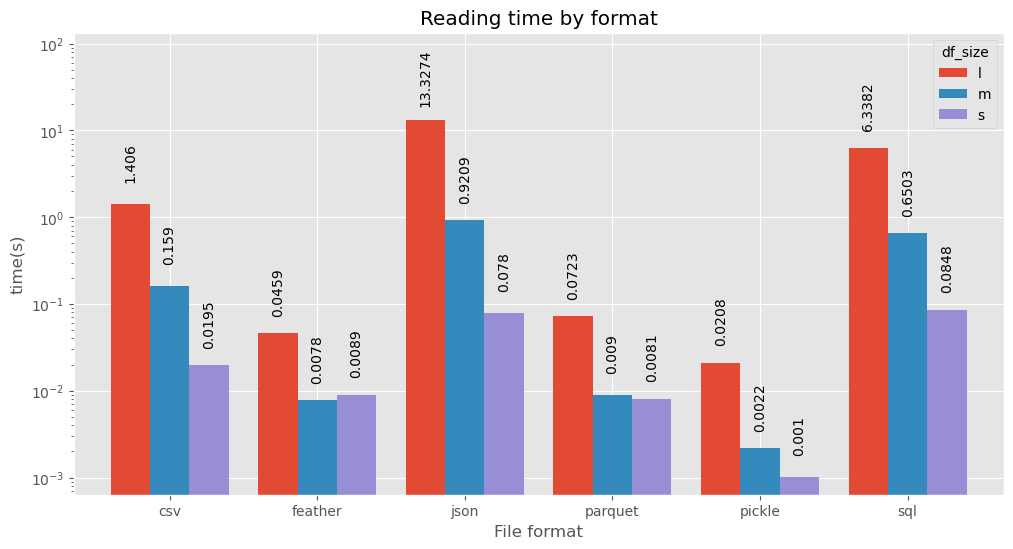

In [36]:
plot_data(grouped['read'], 'Reading time by format', 'time(s)')

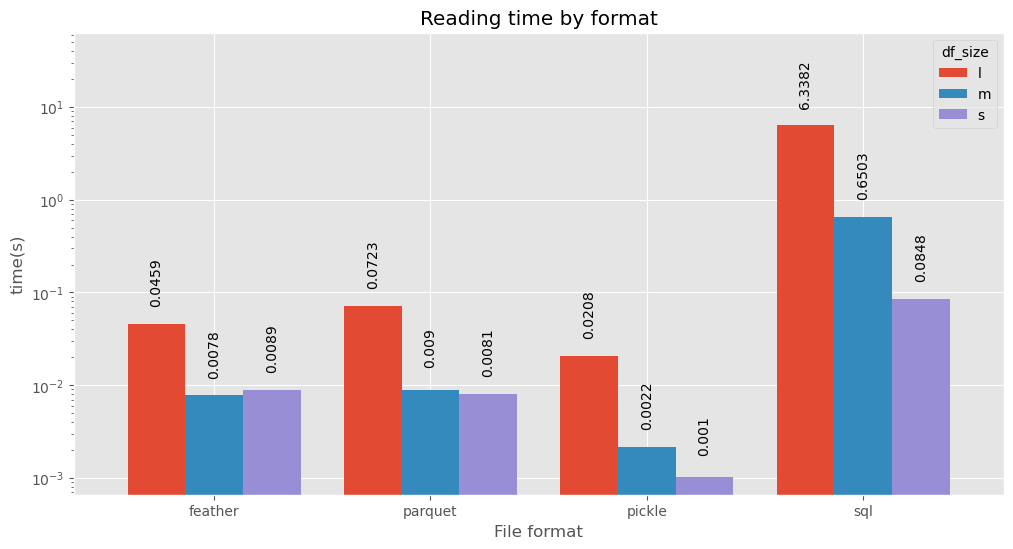

In [37]:
plot_data(binary['read'], 'Reading time by format', 'time(s)')

## write

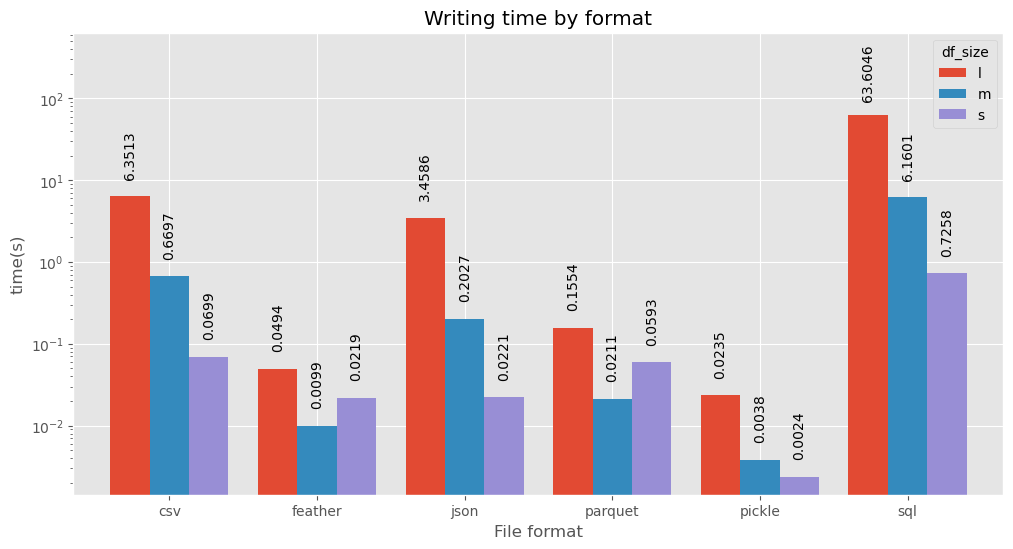

In [38]:
plot_data(grouped['write'], 'Writing time by format', 'time(s)')

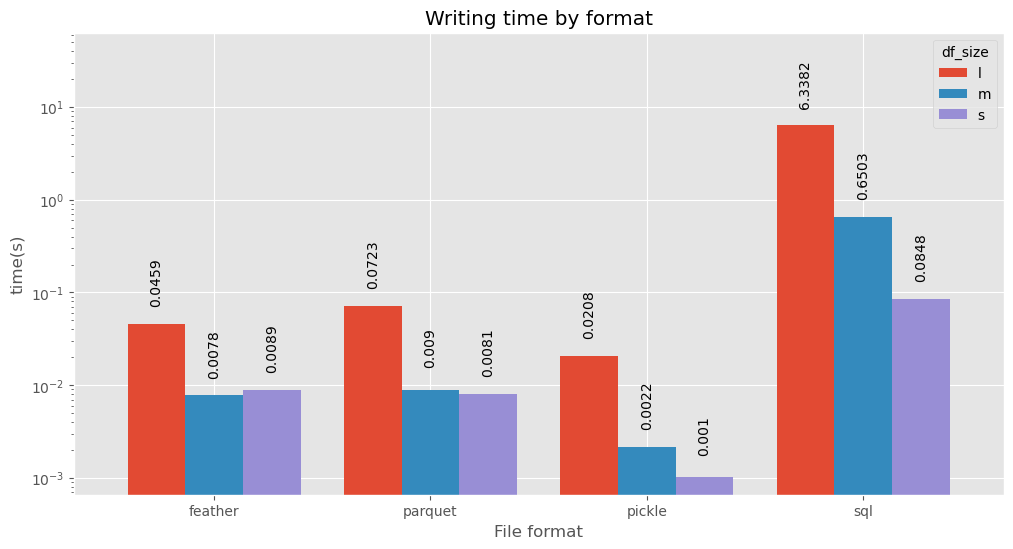

In [39]:
plot_data(binary['read'], 'Writing time by format', 'time(s)')

## size

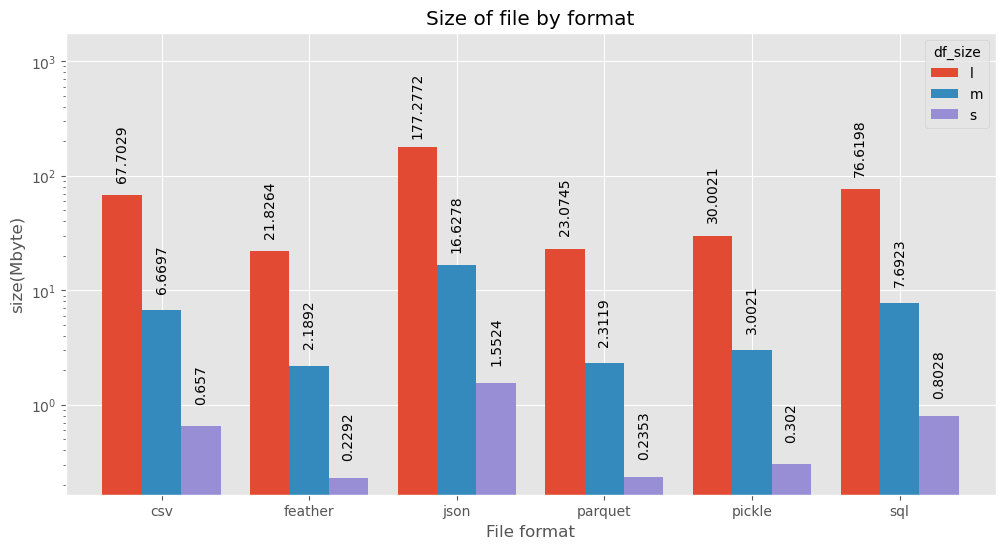

In [40]:
plot_data(grouped['size'], 'Size of file by format', 'size(Mbyte)')

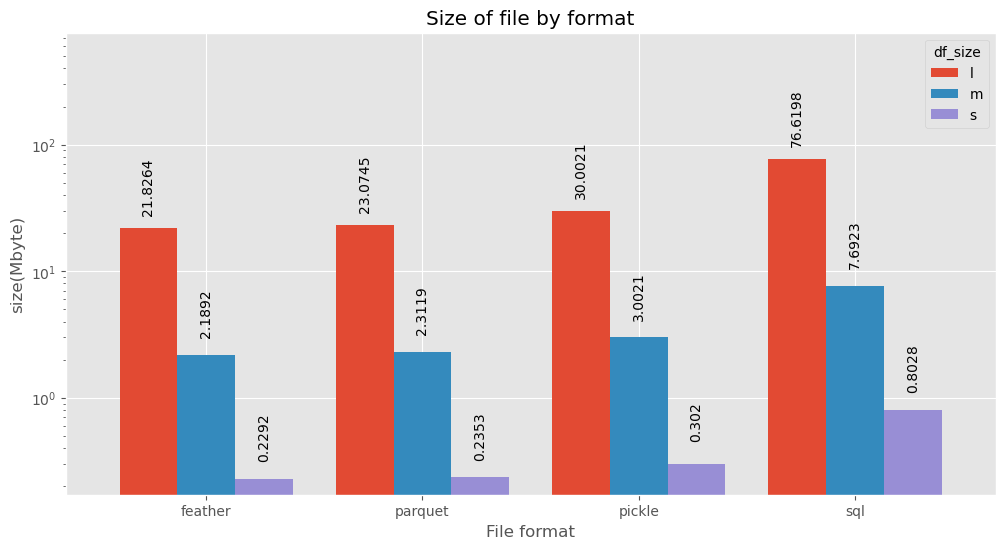

In [41]:
plot_data(binary['size'], 'Size of file by format', 'size(Mbyte)')